This example shows a Total Lagrangian formulation based on 8-node quadrilateral elements. A point force in vertical direction is applied to the right tip of the beam, createing bending-type large displacements.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import meshio
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from scipy.linalg import solve
from scipy.sparse.linalg import eigsh
from scipy.sparse import dok_matrix


# ====================== Element Class ======================
class Element20node3D:  
    def H(self, r, s, t):        
        return self.quadraticElements(r, s, t)
        
    def dhdR(self, r, s, t):
        # dh/dr
        dhdr = np.array([
            (s - 1)*(t - 1)*(2*r + s + t + 1)/8,
            -(s - 1)*(t - 1)*(-2*r + s + t + 1)/8,
            -(s + 1)*(t - 1)*(2*r + s - t - 1)/8,
            -(s + 1)*(t - 1)*(2*r - s + t + 1)/8,
            -(s - 1)*(t + 1)*(2*r + s - t + 1)/8,
            -(s - 1)*(t + 1)*(2*r - s + t - 1)/8,
            (s + 1)*(t + 1)*(2*r + s + t - 1)/8,
            (s + 1)*(t + 1)*(2*r - s - t + 1)/8,
            -r*(s - 1)*(t - 1)/2,
            (s**2 - 1)*(t - 1)/4,
            r*(s + 1)*(t - 1)/2,
            -(s**2 - 1)*(t - 1)/4,
            r*(s - 1)*(t + 1)/2,
            -(s**2 - 1)*(t + 1)/4,
            -r*(s + 1)*(t + 1)/2,
            (s**2 - 1)*(t + 1)/4,
            -(s - 1)*(t**2 - 1)/4,
            (s - 1)*(t**2 - 1)/4,
            -(s + 1)*(t**2 - 1)/4,
            (s + 1)*(t**2 - 1)/4
            ])

        # dh/ds
        dhds = np.array([
            (r - 1)*(t - 1)*(r + 2*s + t + 1)/8,
            -(r + 1)*(t - 1)*(-r + 2*s + t + 1)/8,
            -(r + 1)*(t - 1)*(r + 2*s - t - 1)/8,
            -(r - 1)*(t - 1)*(r - 2*s + t + 1)/8,
            -(r - 1)*(t + 1)*(r + 2*s - t + 1)/8,
            -(r + 1)*(t + 1)*(r - 2*s + t - 1)/8,
            (r + 1)*(t + 1)*(r + 2*s + t - 1)/8,
            (r - 1)*(t + 1)*(r - 2*s - t + 1)/8,
            -(r**2 - 1)*(t - 1)/4,
            s*(r + 1)*(t - 1)/2,
            (r**2 - 1)*(t - 1)/4,
            -s*(r - 1)*(t - 1)/2,
            (r**2 - 1)*(t + 1)/4,
            -s*(r + 1)*(t + 1)/2,
            -(r**2 - 1)*(t + 1)/4,
            s*(r - 1)*(t + 1)/2,
            -(r - 1)*(t**2 - 1)/4,
            (r + 1)*(t**2 - 1)/4,
            -(r + 1)*(t**2 - 1)/4,
            (r - 1)*(t**2 - 1)/4
            ])
        
        # dh/dt
        dhdt = np.array([
            (r - 1)*(s - 1)*(r + s + 2*t + 1)/8,
            -(r + 1)*(s - 1)*(-r + s + 2*t + 1)/8,
            -(r + 1)*(s + 1)*(r + s - 2*t - 1)/8,
            -(r - 1)*(s + 1)*(r - s + 2*t + 1)/8,
            -(r - 1)*(s - 1)*(r + s - 2*t + 1)/8,
            -(r + 1)*(s - 1)*(r - s + 2*t - 1)/8,
            (r + 1)*(s + 1)*(r + s + 2*t - 1)/8,
            (r - 1)*(s + 1)*(r - s - 2*t + 1)/8,
            -(r**2 - 1)*(s - 1)/4,
            (r + 1)*(s**2 - 1)/4,
            (r**2 - 1)*(s + 1)/4,
            -(r - 1)*(s**2 - 1)/4,
            (r**2 - 1)*(s - 1)/4,
            -(r + 1)*(s**2 - 1)/4,
            -(r**2 - 1)*(s + 1)/4,
            (r - 1)*(s**2 - 1)/4,
            -t*(r - 1)*(s - 1)/2,
            t*(r + 1)*(s - 1)/2,
            -t*(r + 1)*(s + 1)/2,
            t*(r - 1)*(s + 1)/2
        ])

        return np.array([dhdr, dhds, dhdt])

    def quadraticElements(self,r, s, t):
        return np.array([
            (1 - r) * (1 - s) * (1 - t) * (-r - s - t -2) /8,
            (1 + r) * (1 - s) * (1 - t) * (r - s - t - 2) /8,
            (1 + r) * (1 + s) * (1 - t) * (r + s - t - 2) /8,
            (1 - r) * (1 + s) * (1 - t) * (-r + s - t - 2) /8,
            (1 - r) * (1 - s) * (1 + t) * (-r - s + t - 2) /8,
            (1 + r) * (1 - s) * (1 + t) * (r - s + t - 2) /8,
            (1 + r) * (1 + s) * (1 + t) * (r + s + t - 2) /8,
            (1 - r) * (1 + s) * (1 + t) * (-r + s + t - 2) /8,
            (1 - r**2) * (1 - s) * (1 - t) /4,
            (1 - s**2) * (1 + r) * (1 - t) /4,
            (1 - r**2) * (1 + s) * (1 - t) /4,
            (1 - s**2) * (1 - r) * (1 - t) /4,
            (1 - r**2) * (1 - s) * (1 + t) /4,
            (1 - s**2) * (1 + r) * (1 + t) /4,
            (1 - r**2) * (1 + s) * (1 + t) /4,
            (1 - s**2) * (1 - r) * (1 + t) /4,
            (1 - t**2) * (1 - r) * (1 - s) /4,
            (1 - t**2) * (1 + r) * (1 - s) /4,
            (1 - t**2) * (1 + r) * (1 + s) /4,
            (1 - t**2) * (1 - r) * (1 + s) /4
        ])

# ====================== Problem Setup ======================
mesh = meshio.read("CircularArcBeamExample.msh")
nodes = mesh.points
elements = mesh.cells_dict["hexahedron20"]
E, nu = 1e7, 0.0 
C = E / (1 - 2 * nu) / (1 + nu) * np.array([[1 - nu, nu, nu, 0, 0 ,0], 
                                            [nu, 1 - nu, nu, 0, 0, 0], 
                                            [nu, nu, 1 - nu, 0 ,0 ,0], 
                                            [0, 0, 0, (1 - 2 * nu) / 2, 0, 0], 
                                            [0, 0, 0, 0, (1 - 2 * nu) / 2, 0], 
                                            [0, 0, 0, 0, 0, (1 - 2 * nu) / 2]])

P0 = 2e-4

GQ_K_x, GQ_K_w = np.polynomial.legendre.leggauss(3)

numN = nodes.shape[0]
numE = elements.shape[0]
ndofs_per_dimension = numN
total_dofs = 3 * ndofs_per_dimension

element_model = Element20node3D()

# ====================== Boundary Conditions ======================
# Step 1: Find nodes on the bottom edge (y == 0)
BC_fix_xdir = np.where(nodes[:, 1] == 0)[0]
# Step 2: Y-direction constraints (offset by ndofs_per_dimension)
BC_fix_ydir = BC_fix_xdir + ndofs_per_dimension
# Step 3: Z-direction constraints (offset by 2 * ndofs_per_dimension)
BC_fix_ydir = BC_fix_xdir + 2 * ndofs_per_dimension
# Step 4: Combine and sort unique constraints
BC_constrained = np.unique(np.concatenate([BC_fix_xdir, BC_fix_ydir]))
# Step 4: Get free DOFs
BC_free = np.setdiff1d(np.arange(0, total_dofs), BC_constrained)

# Find the node with maximum x and maximum y (tip corner)
tip = np.where((nodes[:, 0] > 70.7) & 
               (nodes[:, 1] > 70.7) &
               (np.abs(nodes[:, 2]) > 0.01))[0]

# ====================== Newton-Rhapson Iterations ======================
U = np.zeros((total_dofs,1))
hori = []
for outer_iter in range(100):
    R  = np.zeros((total_dofs, 1))
    R[tip + ndofs_per_dimension] = -outer_iter/10 * P0
    for inner_iter in range(100):
        row_idx, col_idx, data_val_K, data_val_M = [], [], [], []
        F = np.zeros((total_dofs, 1))
        for elem_node_indices in elements:
            phi = np.array(elem_node_indices)
            
            Ke = np.zeros((16, 16))
            Fe = np.zeros((16, 1))

            # ----- Stiffness Matrix Integration -----
            for j, r in enumerate(GQ_K_x):
                for k, s in enumerate(GQ_K_x):

                    J = element_model.dhdR(r, s) @ nodes[elem_node_indices, :2]
                    HrHs = element_model.dhdR(r, s)     # Shape: (2, 16)
                    HxHy = np.linalg.solve(J, HrHs)     # Shape: (2, 16)
                    Hx, Hy = HxHy[0], HxHy[1]           # Extract rows
                    Hx = Hx.reshape(1, -1)
                    Hy = Hy.reshape(1, -1)

                    # G-L strain and 2nd Piola-Kirchhoff stress
                    eps11 = Hx @ U[phi] + 0.5 * (Hx @ U[phi])**2 + 0.5 * (Hx @ U[phi + ndofs_per_dimension])**2
                    eps22 = Hy @ U[phi + ndofs_per_dimension] + 0.5 * (Hy @ U[phi])**2 + 0.5 * (Hy @ U[phi + ndofs_per_dimension])**2
                    eps12 = 0.5 * ( Hy @ U[phi] 
                                   + Hx @ U[phi + ndofs_per_dimension] 
                                   + Hx @ U[phi] * Hy @ U[phi] 
                                   + Hx @ U[phi + ndofs_per_dimension] * Hy @ U[phi + ndofs_per_dimension])
                    S = C @ np.concatenate([eps11, eps22, 2*eps12])

                    # K_linear
                    B_L = np.block([
                        [Hx + Hx @ U[phi] * Hx, Hx @ U[phi + ndofs_per_dimension] * Hx],
                        [Hy @ U[phi] * Hy, Hy + Hy @ U[phi + ndofs_per_dimension] * Hy],
                        [Hy + Hy @ U[phi] * Hx + Hx @ U[phi] * Hy, Hx + Hy @ U[phi + ndofs_per_dimension] * Hx + Hx @ U[phi + ndofs_per_dimension] * Hy]
                    ])
                    K_L = B_L.T @ C @ B_L

                    # K_nonlinear
                    K_NL11 = np.block([
                        [Hx.T * S[0] @ Hx, np.zeros((8, 8))],
                        [np.zeros((8, 8)), Hx.T * S[0] @ Hx]
                        ])
                    K_NL22 = np.block([
                        [Hy.T * S[1] @ Hy, np.zeros((8, 8))],
                        [np.zeros((8, 8)), Hy.T * S[1] @ Hy]
                        ])
                    K_NL12 = np.block([
                        [Hy.T * S[2] @ Hx + Hx.T * S[2] @ Hy, np.zeros((8, 8))],
                        [np.zeros((8, 8)), Hy.T * S[2] @ Hx + Hx.T * S[2] @ Hy]
                    ])
                    K_NL = K_NL11 + K_NL22 + K_NL12

                    Ke += (K_L + K_NL) * np.linalg.det(J) * GQ_K_w[j] * GQ_K_w[k]
                    Fe += B_L.T @ S * np.linalg.det(J) * GQ_K_w[j] * GQ_K_w[k]

            # ----- Collect Stiffness Matrices -----
            for i in range(16):
                for j in range(16):
                    row = phi[i] if i < 8 else phi[i - 8] + ndofs_per_dimension
                    col = phi[j] if j < 8 else phi[j - 8] + ndofs_per_dimension
                    row_idx.append(row)
                    col_idx.append(col)
                    data_val_K.append(Ke[i, j])

            F[np.concatenate([phi, phi + ndofs_per_dimension])] += Fe
        
        # ----- Assemble Global Stiffness Matrix -----
        K = coo_matrix((data_val_K, (row_idx, col_idx)), shape=(total_dofs, total_dofs)).tocsr()
        K_ff = K[BC_free[:, None], BC_free]  # shape: (n_free, n_free)
        # Residual vector for free DOFs
        residual = R[BC_free] - F[BC_free]   # shape: (n_free,)
        # Solve for displacement increment
        del_U = spsolve(K_ff, residual).reshape(-1, 1)
        U[BC_free] += del_U
        # Save condition number for each inner iteration
        if outer_iter == 0 and inner_iter == 0:
            cond_Kff_arr = []
        cond_Kff = np.linalg.cond(K_ff.toarray())
        cond_Kff_arr.append(cond_Kff)
        #print(f"Condition number of K_ff: {cond_Kff:.3e}")
        if np.linalg.norm(residual) < 1e-9 and np.linalg.norm(del_U) < 1e-9:
            print(f"Converged after {outer_iter+1} outer iterations and {inner_iter+1} inner iterations.")
            break
    
    hori.append(U[tip, 0])


TypeError: Element20node3D.dhdR() missing 1 required positional argument: 't'

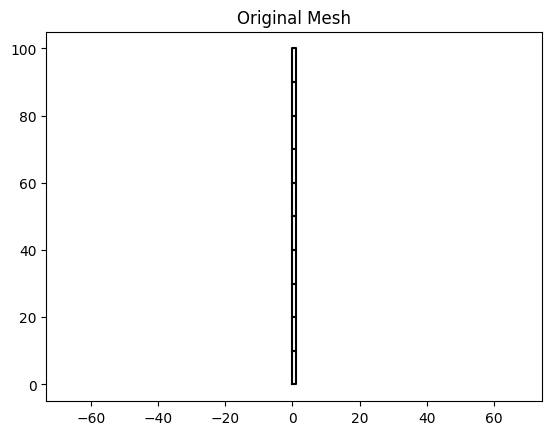

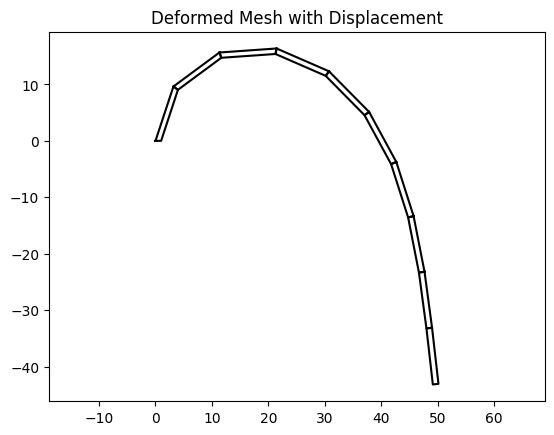

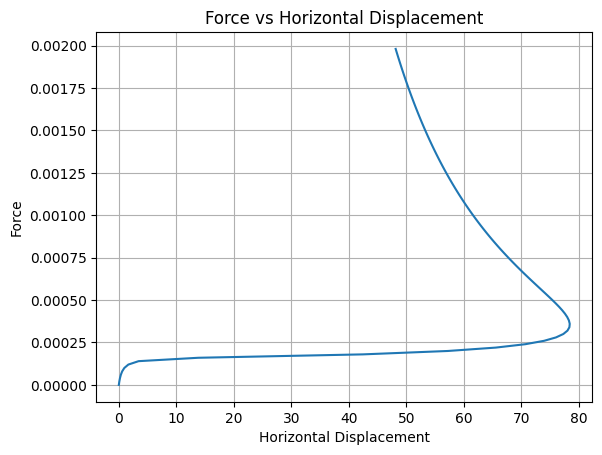

In [9]:
def drawmesh(nodes, elements, title=''):
    plt.figure()
    for elem in elements:
        pts = np.append(elem[:4], elem[0])  # Close the loop
        plt.plot(nodes[pts, 0], nodes[pts, 1], 'k-')
    plt.title(title)
    plt.axis('equal')
    plt.show()

# ====================== Visualization ======================          
drawmesh(nodes, elements, title='Original Mesh')
drawmesh(nodes[:,:2] + U.reshape(-1, 2, order='F'), elements, title='Deformed Mesh with Displacement')
plt.figure()
plt.plot(hori, np.arange(len(hori))/10*P0)
plt.xlabel('Horizontal Displacement')
plt.ylabel('Force')
plt.title('Force vs Horizontal Displacement')
plt.grid(True)
plt.show()